# Figure 7

In this notebook, we'll generate figure panels for use in Figure 7 that are based on DEGs.

In this figure, we show example scatterplots for comparisons of DEG results between drug treatments as well as a barplot showing patterns of enriched DEGs between different drugs.

For patterning, we'll use the 500 top up- and down-regulated genes for each drug.

## Load packages

hise: The Human Immune System Explorer R SDK package  
purrr: Functional programming tools  
dplyr: Dataframe handling functions  
ggplot2: plotting functions  
ggrepel: text plotting with repulsion  
ggrastr: raster plotting for ggplot  
cowplot: multi-panel plot assembly

In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(hise)
quiet_library(purrr)
quiet_library(dplyr)
quiet_library(ggplot2)
quiet_library(ggrepel)
quiet_library(ggrastr)
quiet_library(cowplot)
quiet_library(tidyr)

In [2]:
out_dir <- "output/figure_7"
if(!dir.exists(out_dir)) { dir.create(out_dir, recursive = TRUE) }

## Retrieve files

Now, we'll use the HISE SDK package to retrieve the analysis results for DEG, Hallmark Pathway enrichment, and motif enrichment.

DEG: Differentially expressed genes

In [3]:
deg_uuid <- list("fc83b89f-fd26-43b8-ac91-29c539703a45")

In [4]:
deg_fres <- cacheFiles(deg_uuid)
deg_file <- list.files(
    paste0("cache/",deg_uuid),
    recursive = TRUE, full.names = TRUE
)

submitting request as query ID first...

retrieving files using fileIDS...



## Scatter plots

### Parameters and colors

In [5]:
fdr_cutoff <- 0.05
time_point <- 24

In [6]:
comparisons <- list(
    bor_len = c("lenalidomide", "bortezomib"),
    bor_dex = c("dexamethasone", "bortezomib"),
    len_dex = c("dexamethasone", "lenalidomide")
)

In [7]:
point_colors <- data.frame(
    x_dir = c("up", "dn", "up", "dn", "up", "dn", "no", "no", "no"),
    y_dir = c("up", "up", "dn", "dn", "no", "no", "up", "dn", "no"),
    color = c("darkred", "limegreen", "limegreen", "darkblue", 
              "orange", "skyblue", "orange", "skyblue",
              "gray80")
)

In [8]:
type_colors <- read.csv("../common/color_sets/aifi_cell_type_colors.csv")

In [9]:
type_colors <- type_colors %>%
  filter(aifi_cell_type != "t_cd8_mait")

These genes will get callouts in the scatter plots. We follow up these genes with flow cytometry experiments.

In [10]:
label_genes <- c(
    "CD69","CD74","CXCR4","IL2RA","IL6ST","IL7R","SLAMF1","TNFRSF4"
)

### Prepare DEGs

In [11]:
all_deg <- read.csv(deg_file)

For the purposes of these scatter plots, we'll exclude any gene without a logFC value.

In [12]:
all_deg <- all_deg %>%
  mutate(
      direction_sign = ifelse(
          is.na(logFC),
          sign(coef_D),
          sign(logFC)
      ),
      direction = ifelse(
          direction_sign == 1,
          "up", "dn"
      )
  )

In [13]:
timepoint_deg <- all_deg %>%
  filter(timepoint == time_point)

In [14]:
type_deg <- split(timepoint_deg, timepoint_deg$aifi_cell_type)

### Build comparison plots

This helper function will prepare the plot coordinates for a comparison between two samples so that points are distributed based on logFC for one treatment along the x-axis and for the second treatment along the y-axis.

This will also assign colors based on adjusted p-value cutoffs to label genes that are regulated in the same or different direction.

In [15]:
build_comparison_data <- function(
    deg_data,
    x_treat,
    y_treat,
    point_colors
) {
    x_data <- deg_data %>%
      filter(fg == x_treat) %>%
      mutate(direction = ifelse(
          adjP >= fdr_cutoff,
          "no", direction
      )) %>%
      rename(x_lfc = logFC,
             x_fdr = adjP,
             x_dir = direction,
             gene = gene) %>%
      select(gene, x_lfc, x_fdr, x_dir)
    y_data <- deg_data %>%
      filter(fg == y_treat) %>%
      mutate(direction = ifelse(
          adjP >= fdr_cutoff,
          "no", direction
      )) %>%
      rename(y_lfc = logFC,
             y_fdr = adjP,
             y_dir = direction,
             gene = gene) %>%
      select(gene, y_lfc, y_fdr, y_dir)
    
    plot_data <- left_join(x_data, y_data, by = "gene")
    plot_data <- left_join(plot_data, point_colors, by = c("x_dir", "y_dir"))
    
    # Remove genes that don't have a logFC value for one or the other treatment
    plot_data <- plot_data[complete.cases(plot_data),]
    
    plot_data
}

This helper function will assemble the plots for each comparison

In [16]:
build_scatter <- function(
    plot_data,
    label_genes,
    x_label,
    y_label
) {
    nsig_data <- plot_data %>%
      filter(x_dir == "no" & y_dir == "no")
    sig_data <- plot_data %>%
      filter(x_dir != "no" | y_dir != "no")
    
    label_df <- plot_data %>%
      filter(gene %in% label_genes) %>%
      arrange(x_lfc) %>%
      mutate(ypos = max(plot_data$y_lfc) * 0.8,
             xpos = seq(min(plot_data$x_lfc) * 0.9, max(plot_data$x_lfc) * 0.9, length.out = n()))
    
    ggplot() +
      geom_vline(data = data.frame(x = 0),
                 aes(xintercept = x), linewidth = 0.2) +
      geom_hline(data = data.frame(y = 0),
                 aes(yintercept = y), linewidth = 0.2) +
      geom_point_rast(data = nsig_data,
                 aes(x = x_lfc,
                     y = y_lfc,
                     color = color),
                 pch = 16,
                 size = 0.1) +
      geom_point(data = sig_data,
                 aes(x = x_lfc,
                     y = y_lfc,
                     color = color),
                 pch = 16,
                 size = 1) +
      geom_segment(
          data = label_df,
          aes(x = xpos, xend = x_lfc,
              y = ypos, yend = y_lfc),
          color = "black",
          linewidth = 0.1
      ) +
      geom_label(
          data = label_df,
          aes(x = xpos, y = ypos,
              label = gene, color = color),
          vjust = 0
      ) +
      # geom_label_repel(data = label_df,
      #                 aes(x = x_lfc,
      #                     y = y_lfc,
      #                     label = gene,
      #                     color = color),
      #                  max.overlaps = 20) +
    scale_x_continuous(x_label) +
    scale_y_continuous(y_label) +
    scale_color_identity() +
    scale_fill_identity() +
    theme_bw() +
    theme(axis.ticks = element_blank(),
          panel.grid.minor = element_blank())
}

This section iterates over each cell type to generate plots for each pair of drug treatments

In [17]:
comparison_data <- map(
    type_deg,
    function(deg) {
        map(comparisons,
            function(comparison) {
                build_comparison_data(
                    deg, 
                    comparison[1], 
                    comparison[2], 
                    point_colors) 
            }
        )
    }
)

In [18]:
type_scatters <- map(
    type_deg,
    function(deg) {
        type_plots <- map(
            comparisons,
            function(comparison) {
                pd <- build_comparison_data(deg, comparison[1], comparison[2], point_colors)
                build_scatter(pd, label_genes, comparison[1], comparison[2])
            }
        )
        type_plots
    }
)
type_scatters <- type_scatters[type_colors$aifi_cell_type]

We can view all of the scatter plots here:

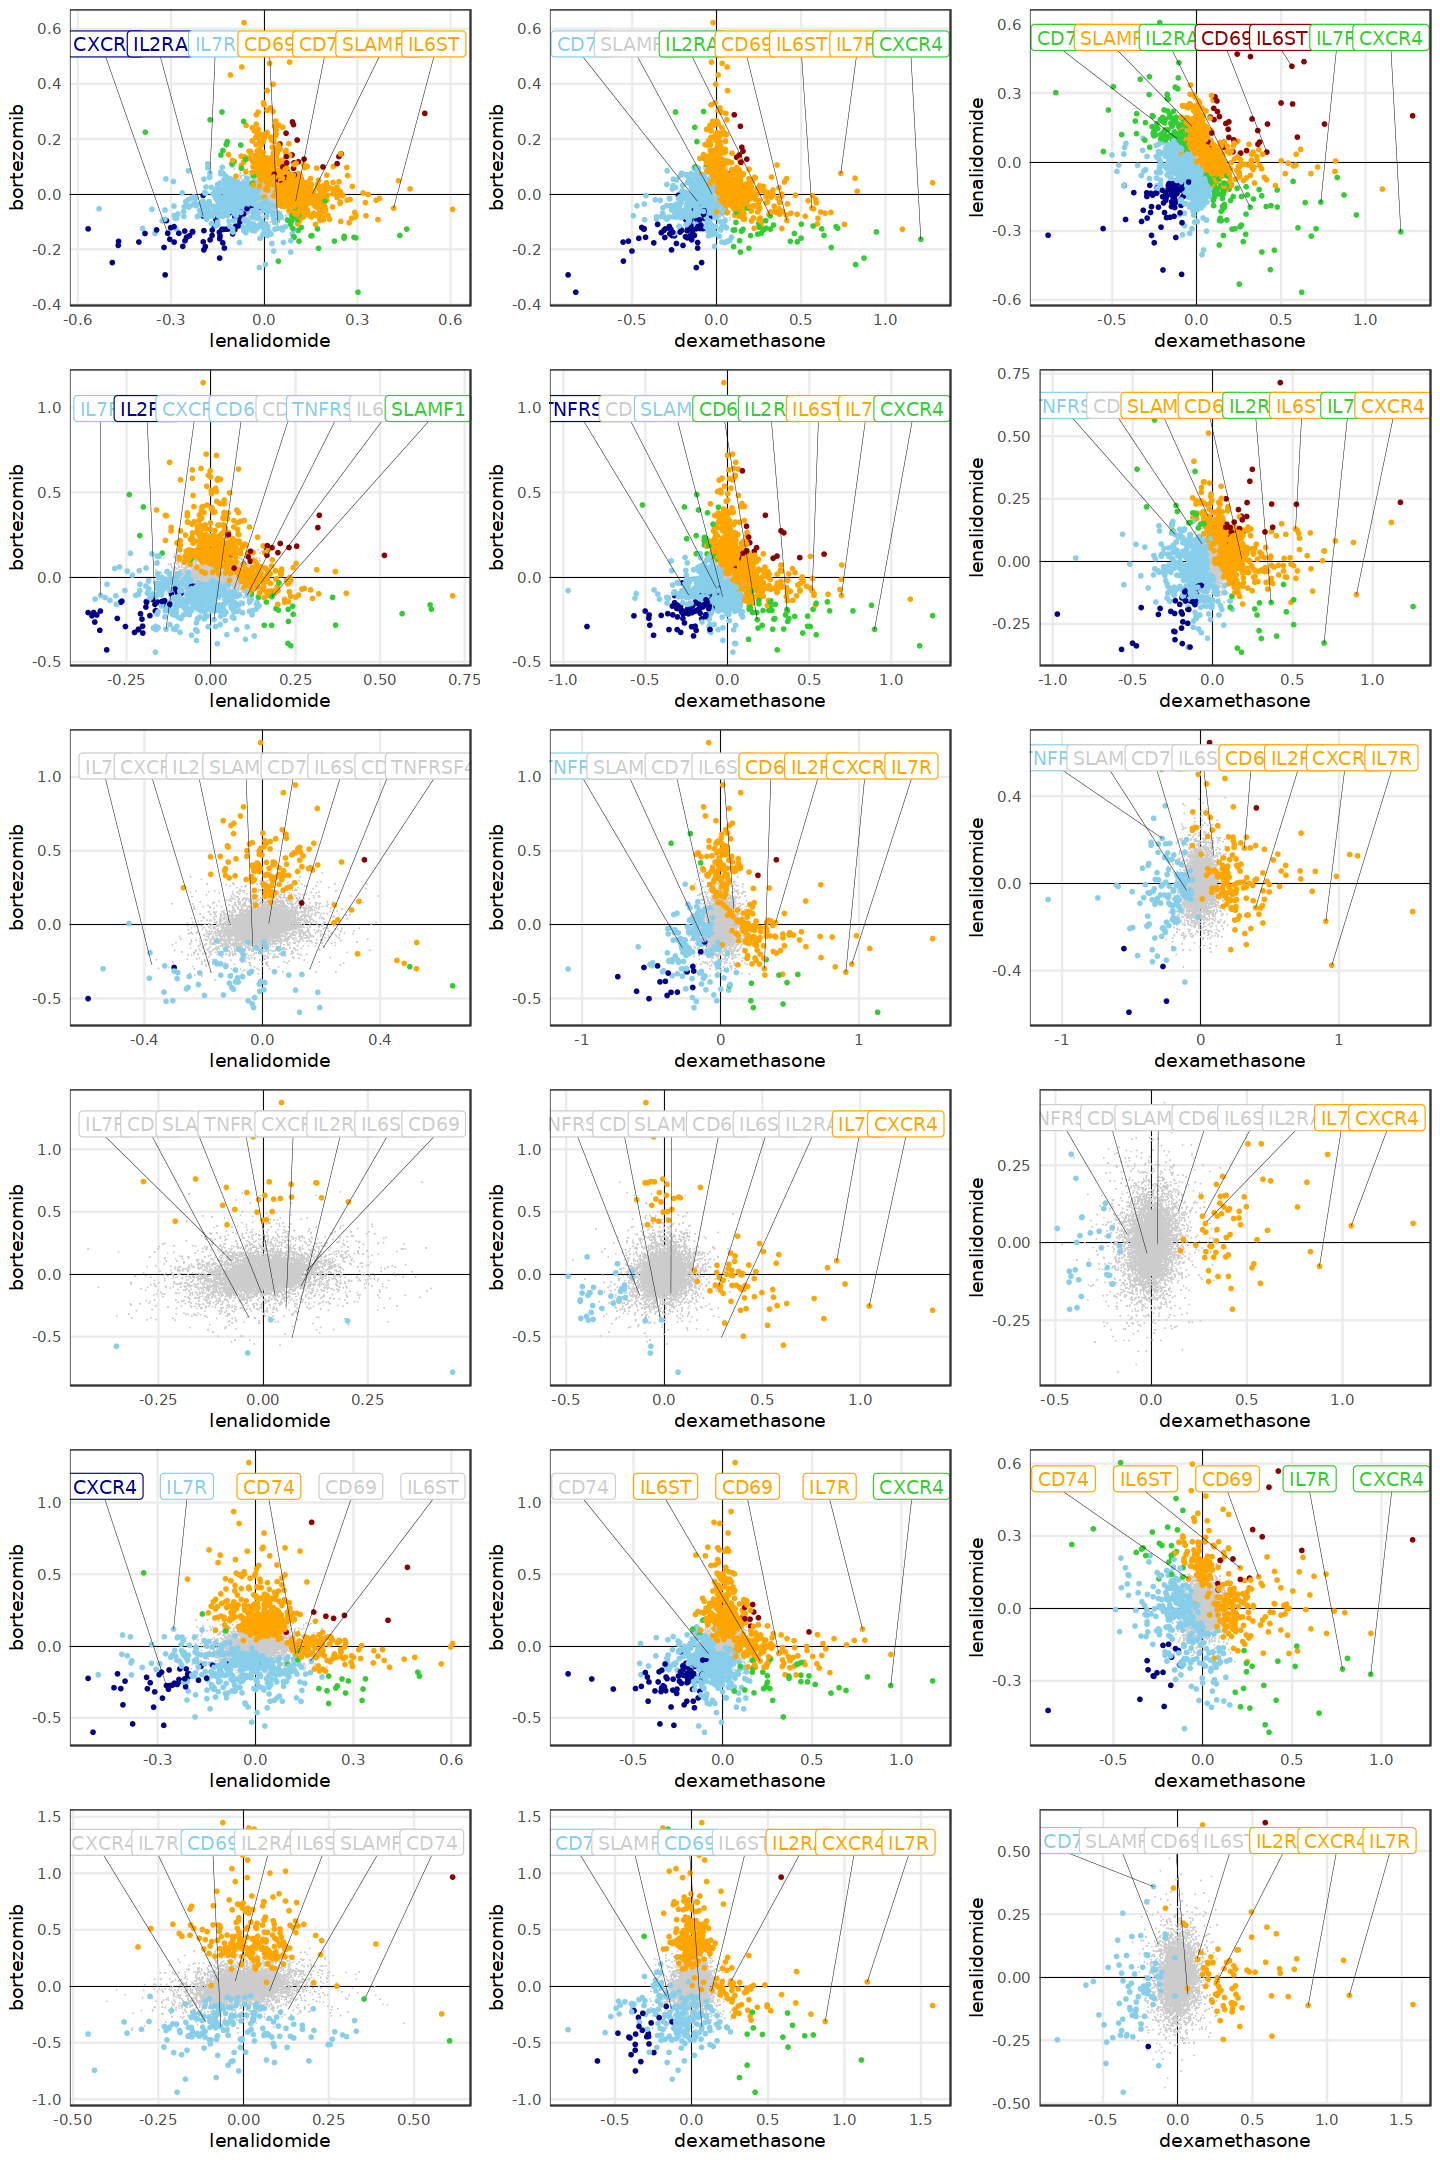

In [19]:
options(repr.plot.width = 12, repr.plot.height = 18)
plot_grid(
    plotlist = unlist(type_scatters, recursive = FALSE),
    ncol = 3
)

This is a bit overwhelming for a main figure. Let's select a couple of examples for the main presentation

In [20]:
cd4_naive_len_dex_plot_data <- comparison_data[["t_cd4_naive"]][[3]]
cd4_naive_len_dex_plot <- type_scatters[["t_cd4_naive"]][[3]]

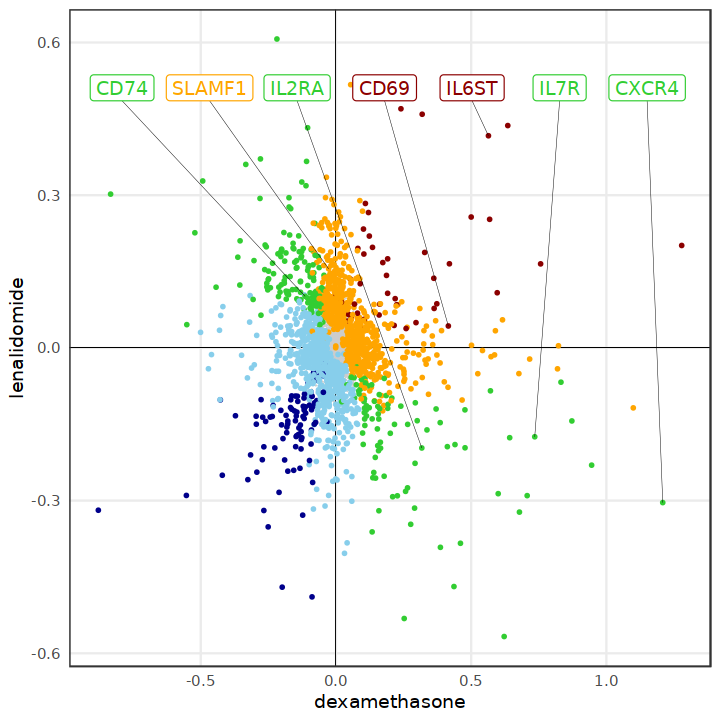

In [21]:
options(repr.plot.width = 6, repr.plot.height = 6)
cd4_naive_len_dex_plot

In [22]:
write.csv(
    cd4_naive_len_dex_plot_data,
    file.path(out_dir, paste0("deg_scatter_cd4_naive_24_dex_len_data_", Sys.Date(), ".csv")),
    quote = FALSE,
    row.names = FALSE
)
ggsave(
    file.path(out_dir, paste0("deg_scatter_cd4_naive_24_dex_len_", Sys.Date(), ".pdf")),
    cd4_naive_len_dex_plot,
    width = 6, height = 6
)

In [23]:
cd4_cm_bor_dex_plot_data <- comparison_data[["t_cd4_cm"]][[2]]
cd4_cm_bor_dex_plot <- type_scatters[["t_cd4_cm"]][[2]]

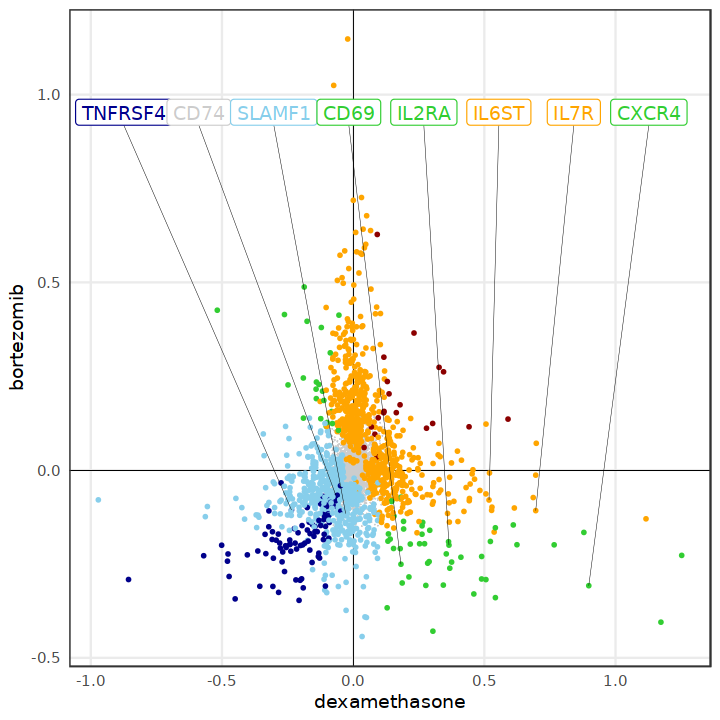

In [24]:
options(repr.plot.width = 6, repr.plot.height = 6)
cd4_cm_bor_dex_plot

In [25]:
write.csv(
    cd4_cm_bor_dex_plot_data,
    file.path(out_dir, paste0("deg_scatter_cd4_cm_24_dex_len_data_", Sys.Date(), ".csv")),
    quote = FALSE,
    row.names = FALSE
)
ggsave(
    file.path(out_dir, paste0("deg_scatter_cd4_cm_24_dex_len_", Sys.Date(), ".pdf")),
    cd4_cm_bor_dex_plot,
    width = 6, height = 6
)

## Regulatory pattern barplots

In [26]:
label_genes <- c(
    "CD69","CD74","CXCR4","IL2RA","IL6ST","IL7R","SLAMF1","TNFRSF4"
)

In [27]:
top_deg <- all_deg %>%
  group_by(aifi_cell_type, fg, timepoint, direction) %>%
  arrange(nomP) %>%
  slice(1:500) %>%
  ungroup()

In [28]:
deg_patterns <- top_deg %>%
  group_by(aifi_cell_type, timepoint, gene) %>%
  summarise(bor = ifelse("bortezomib" %in% fg, direction[fg == "bortezomib"], "nc"),
            len = ifelse("lenalidomide" %in% fg, direction[fg == "lenalidomide"], "nc"),
            dex = ifelse("dexamethasone" %in% fg, direction[fg == "dexamethasone"], "nc"),
            n_treat = n(),
            mean_abs_lfc = mean(abs(logFC)),
            .groups = "keep") %>%
  ungroup()

In [29]:
pattern_counts <- deg_patterns %>%
  arrange(desc(mean_abs_lfc)) %>%
  group_by(aifi_cell_type, timepoint, n_treat, bor, len, dex) %>%
  summarise(n_genes = n(), 
            genes = list(sort(gene)),
            top_genes = list(unique(c(gene[1:3],gene[gene %in% label_genes]))),
            .groups = "keep") %>%
  mutate(top_genes = map(top_genes, function(g) { g[!is.na(g)] })) %>%
  ungroup() %>%
  arrange(aifi_cell_type, timepoint, desc(n_genes))

In [30]:
overlap_counts <- pattern_counts %>%
  filter(n_treat > 1)

In [31]:
plot_overlaps <- function(
    overlap_counts,
    cell_type,
    time_point) {
    plot_data <- overlap_counts %>%
      filter(aifi_cell_type == cell_type,
             timepoint == time_point) %>%
      mutate(ypos = n():1,
             top_genes = map_chr(top_genes, paste, collapse = ", "))
    
    rect_data <- plot_data %>%
      select(ypos, bor, len, dex) %>%
      pivot_longer(c(bor, len, dex),
                   values_to = "direction",
                   names_to = "treat")
    
    treat_pos <- data.frame(
        treat = c("bor","len","dex"),
        xmin = c(-26, -18, -10),
        xmax = c(-18, -10, -2)
    )
    
    rect_data <- rect_data %>%
      left_join(treat_pos)
    
    marker_data <- plot_data %>%
      filter(map_lgl(genes, function(g) { length(intersect(g, label_genes)) > 0 })) %>%
      mutate(marker_genes = map_chr(genes, function(g) { paste(intersect(g, label_genes), collapse = ", ") }))
    
    ggplot() +
      geom_rect(
          data = rect_data,
          aes(xmin = xmin, xmax = xmax,
              ymin = ypos - 0.5, ymax = ypos + 0.5,
              fill = direction),
          color = "gray40"
      ) +
      geom_point(
          data = rect_data %>%
                  filter(direction == "up"),
          aes(x = xmin + 4,
              y = ypos),
          color = "orangered",
          fill = "orangered",
          pch = 24,
          size = 4
      ) +
      geom_point(
          data = rect_data %>%
                  filter(direction == "dn"),
          aes(x = xmin + 4,
              y = ypos),
          color = "dodgerblue",
          fill = "dodgerblue",
          pch = 25,
          size = 4
      ) +
      geom_rect(
          data = plot_data,
          aes(xmin = 0, xmax = n_genes/2,
              ymin = ypos - 0.35, ymax = ypos + 0.35),
          fill = "gray70",
          color = "black",
          linewidth = 0.2
      ) +
      geom_text(
          data = plot_data,
          aes(x = n_genes/2 + 1,
              y = ypos,
              label = top_genes),
          hjust = 0
      ) +
      scale_fill_manual(
          breaks = c("dn","nc","up"),
          values = c("skyblue", "gray80", "orange")
      ) +
      scale_x_continuous(
          "",
          limits = c(-30, 120),
          expand = c(0,0),
          breaks = seq(0,37.5,12.5),
          labels = seq(0,75,25)
      ) +
      scale_y_continuous(
          "",
          expand = c(0,0)
      ) +
      theme_bw() +
      theme(axis.text.y = element_blank(),
            axis.ticks = element_blank(),
            panel.grid.major.y = element_blank(),
            panel.grid.minor.y = element_blank(),
            panel.grid.minor.x = element_blank(),
            panel.border = element_blank(),
            legend.position = "none")
}

Joining with `by = join_by(treat)`


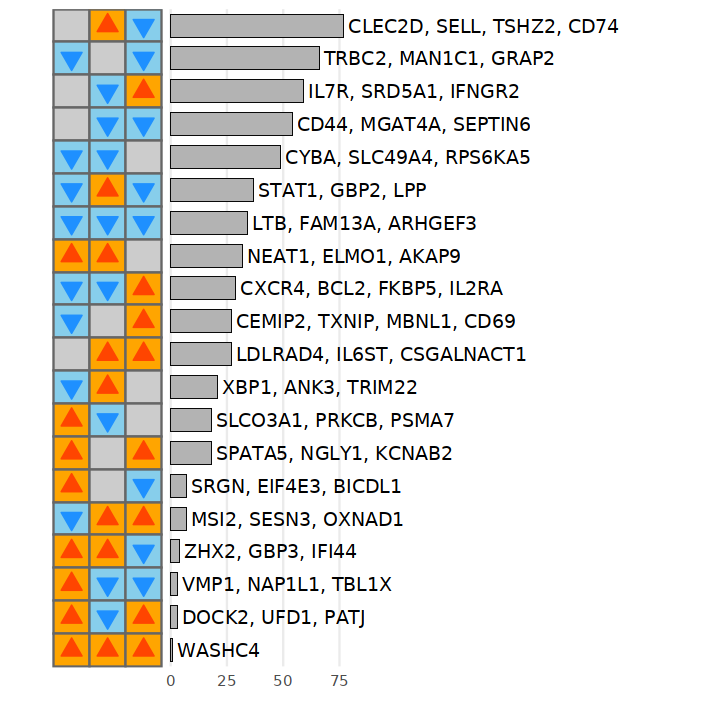

In [32]:
pattern_plot_t_cd4_naive_24 <- plot_overlaps(
    overlap_counts,
    "t_cd4_naive",
    24
)
pattern_plot_t_cd4_naive_24

In [33]:
ggsave(
    file.path(out_dir, paste0("pattern_barplot_t_cd4_naive_24_", Sys.Date(), ".pdf")),
    pattern_plot_t_cd4_naive_24,
    width = 6, height = 6
)

In [34]:
out_plot_data <- overlap_counts %>%
    filter(aifi_cell_type == "t_cd4_naive",
         timepoint == 24) %>%
    mutate(ypos = n():1,
           genes = map_chr(genes, paste, collapse = ";"),
           top_genes = map_chr(top_genes, paste, collapse = ";"))

In [35]:
write.csv(
    out_plot_data,
    file.path(out_dir, paste0("pattern_data_t_cd4_naive_24_", Sys.Date(), ".csv")),
    quote = FALSE,
    row.names = FALSE
)

Joining with `by = join_by(treat)`


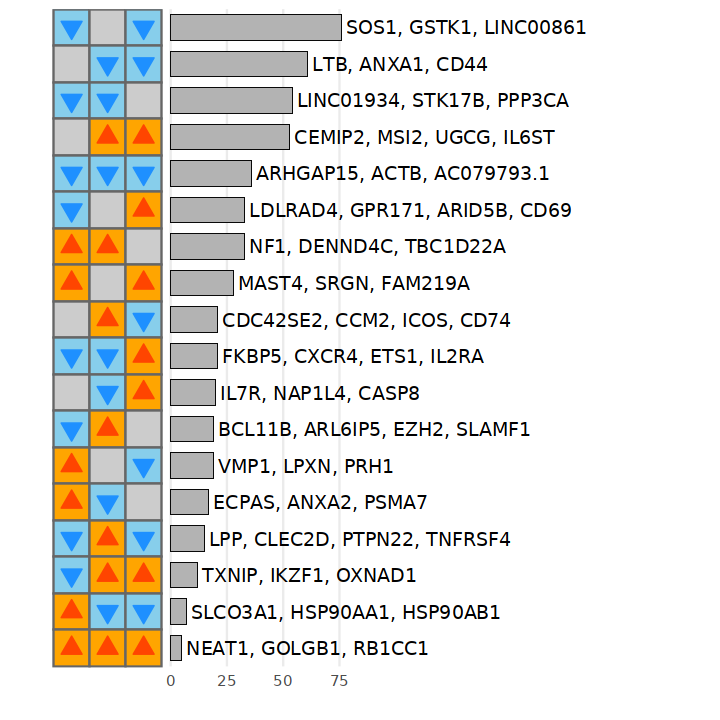

In [36]:
pattern_plot_t_cd4_cm_24 <- plot_overlaps(
    overlap_counts,
    "t_cd4_cm",
    24
)
pattern_plot_t_cd4_cm_24

In [37]:
ggsave(
    file.path(out_dir, paste0("pattern_barplot_t_cd4_cm_24_", Sys.Date(), ".pdf")),
    pattern_plot_t_cd4_cm_24,
    width = 6, height = 6
)

In [38]:
out_plot_data <- overlap_counts %>%
    filter(aifi_cell_type == "t_cd4_cm",
         timepoint == 24) %>%
    mutate(ypos = n():1,
           genes = map_chr(genes, paste, collapse = ";"),
           top_genes = map_chr(top_genes, paste, collapse = ";"))

In [39]:
write.csv(
    out_plot_data,
    file.path(out_dir, paste0("pattern_data_t_cd4_cm_24_", Sys.Date(), ".csv")),
    quote = FALSE,
    row.names = FALSE
)

## Marker Gene Heatmaps

Heatmap plots for selected oppositely-regulated genes.

In [40]:
treat_colors <- read.csv("../common/color_sets/treat_time_colors.csv")
treat_colors <- treat_colors %>%
  select(treat_time, treat_order) %>%
  mutate(treat_order = ifelse(grepl("len", treat_time), treat_order + 0.5, treat_order),
         treat_order = ifelse(grepl("dex", treat_time), treat_order + 1, treat_order))
type_colors <- read.csv("../common/color_sets/aifi_cell_type_colors.csv")

In [41]:
target_genes <- c(
    "CD69","CD74","CXCR4","IL2RA","IL6ST","IL7R","SLAMF1","TNFRSF4"
)

In [42]:
plot_deg <- all_deg %>%
  filter(gene %in% target_genes) %>%
  mutate(treat_time = paste0(fg, "_", timepoint)) %>%
  select(aifi_cell_type, gene, fg, timepoint, treat_time, logFC, nomP, adjP)

In [43]:
plot_df <- plot_deg %>%
  left_join(treat_colors) %>%
  left_join(type_colors)

Joining with `by = join_by(treat_time)`
Joining with `by = join_by(aifi_cell_type)`


In [44]:
write.csv(
    plot_df,
    file.path(out_dir, paste0("marker_heatmap_data_", Sys.Date(), ".csv")),
    quote = FALSE,
    row.names = FALSE
)

In [45]:
missing_panels <- expand.grid(
    treat_order = unique(plot_df$treat_order),
    cell_type_ypos = unique(plot_df$cell_type_ypos),
    gene = target_genes
)
missing_panels <- missing_panels %>%
  filter(!paste(treat_order, cell_type_ypos, gene) %in% paste(plot_df$treat_order, plot_df$cell_type_ypos, plot_df$gene))

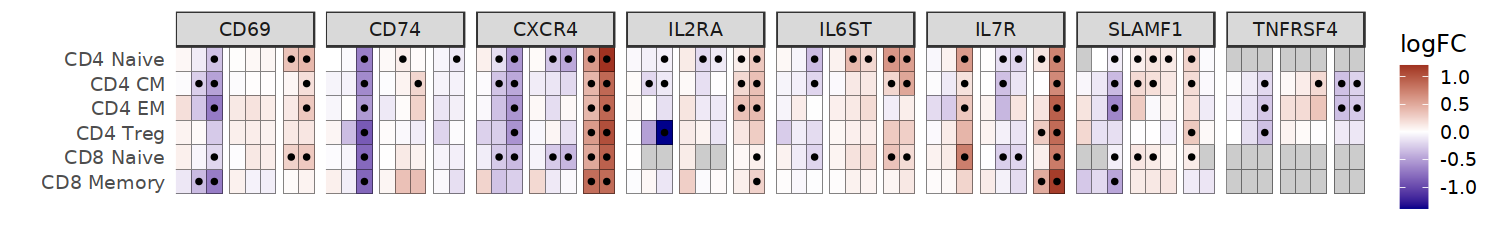

In [46]:
options(repr.plot.width = 12.5, repr.plot.height = 2)
marker_heatmap <- ggplot() +
  geom_tile(
      data = missing_panels,
      aes(x = treat_order,
          y = cell_type_ypos),
      fill = "gray80",
      color = "black"
  ) +
  geom_tile(
      data = plot_df,
      aes(x = treat_order,
          y = cell_type_ypos,
          fill = logFC),
      color = "black"
  ) +
  geom_point(
      data = plot_df %>% filter(adjP < 0.01),
      aes(x = treat_order,
          y = cell_type_ypos),
      pch = 16
  ) +
  scale_fill_gradient2(low = "darkblue", mid = "white", high = "darkred") +
  scale_y_continuous(
      "",
      breaks = type_colors$cell_type_ypos,
      labels = type_colors$cell_type_label,
      expand = c(0,0)
  ) +
  scale_x_continuous(
      "",
      breaks = treat_colors$treat_order,
      labels = treat_colors$lab_label,
      expand = c(0,0)
  ) +
  facet_wrap(~ gene, ncol = 8) +
  theme_bw(base_size = 14) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3),
        axis.ticks = element_blank(),
        panel.grid.minor = element_blank(),
        panel.grid.major = element_blank(),
        panel.border = element_blank())
marker_heatmap

In [47]:
ggsave(
    file.path(out_dir, paste0("marker_heatmap_", Sys.Date(), ".pdf")),
    marker_heatmap,
    width = 12.5, height = 2
)

# Store results in HISE

Finally, we store the output file in our Collaboration Space for later retrieval and use. We need to provide the UUID for our Collaboration Space (aka `studySpaceId`), as well as a title for this step in our analysis process.

The hise function `uploadFiles()` also requires the FileIDs from the original fileset for reference.

In [48]:
study_space_uuid <- "40df6403-29f0-4b45-ab7d-f46d420c422e"
title <- paste("VRd TEA-seq Figure 7", Sys.Date())

In [49]:
out_files <- list.files(
    "output/figure_7",
    full.names = TRUE
)
out_list <- as.list(out_files)

In [50]:
out_list

[[1]]
[1] "output/figure_7/deg_scatter_cd4_cm_24_dex_len_2023-10-24.pdf"

[[2]]
[1] "output/figure_7/deg_scatter_cd4_cm_24_dex_len_data_2023-10-24.csv"

[[3]]
[1] "output/figure_7/deg_scatter_cd4_naive_24_dex_len_2023-10-24.pdf"

[[4]]
[1] "output/figure_7/deg_scatter_cd4_naive_24_dex_len_data_2023-10-24.csv"

[[5]]
[1] "output/figure_7/marker_heatmap_2023-10-24.pdf"

[[6]]
[1] "output/figure_7/marker_heatmap_data_2023-10-24.csv"

[[7]]
[1] "output/figure_7/pattern_barplot_t_cd4_cm_24_2023-10-24.pdf"

[[8]]
[1] "output/figure_7/pattern_barplot_t_cd4_naive_24_2023-10-24.pdf"

[[9]]
[1] "output/figure_7/pattern_data_t_cd4_cm_24_2023-10-24.csv"

[[10]]
[1] "output/figure_7/pattern_data_t_cd4_naive_24_2023-10-24.csv"

In [51]:
uploadFiles(
    files = out_list,
    studySpaceId = study_space_uuid,
    title = title,
    inputFileIds = deg_uuid,
    store = "project",
    doPrompt = FALSE
)

$files
$files[[1]]
[1] "output/figure_7/deg_scatter_cd4_cm_24_dex_len_2023-10-24.pdf"

$files[[2]]
[1] "output/figure_7/deg_scatter_cd4_cm_24_dex_len_data_2023-10-24.csv"

$files[[3]]
[1] "output/figure_7/deg_scatter_cd4_naive_24_dex_len_2023-10-24.pdf"

$files[[4]]
[1] "output/figure_7/deg_scatter_cd4_naive_24_dex_len_data_2023-10-24.csv"

$files[[5]]
[1] "output/figure_7/marker_heatmap_2023-10-24.pdf"

$files[[6]]
[1] "output/figure_7/marker_heatmap_data_2023-10-24.csv"

$files[[7]]
[1] "output/figure_7/pattern_barplot_t_cd4_cm_24_2023-10-24.pdf"

$files[[8]]
[1] "output/figure_7/pattern_barplot_t_cd4_naive_24_2023-10-24.pdf"

$files[[9]]
[1] "output/figure_7/pattern_data_t_cd4_cm_24_2023-10-24.csv"

$files[[10]]
[1] "output/figure_7/pattern_data_t_cd4_naive_24_2023-10-24.csv"


$traceId
[1] "fa4c7ea5-14ca-47f8-ba34-0976c38e44c1"

In [52]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] tidyr_1.3.0   cowplot_1.1.1 ggrastr_1.0.2 ggrepel_0.9.3 ggplot2_3.4.3
[6] dplyr_1.1.3   purrr_1.0.2   hise_2.16.0  

loaded via a namespace (and not attached):
 [1] utf8_1.2.3        generics_0.1.3    bitops_1.0-7      digest_0.6.33    
 [5] magrittr_2.0.3    evaluate_0.21     grid_4.3.1        pbdZMQ_0.3-10